# Multi-label classification

In this notebook we will consider three classes of patients:
* Healthy: Label 0
* Mild Heart Failure: Label 1
* Severe Heart Failure: Label 2

We will consider two features - **EF** and **GLS**.

### Libraries and dataset
Run the code bellow to load the libraries, dataset, create the feature matrix `X` and label vector `y` and finally plot the dataset. Note that we updated the function `PlotData` to deal with 3 classes.

Feature matrix X dimensions:  (120, 2)
Target vector y dimensions:  (120,)
Labels:  [0. 1. 2.]


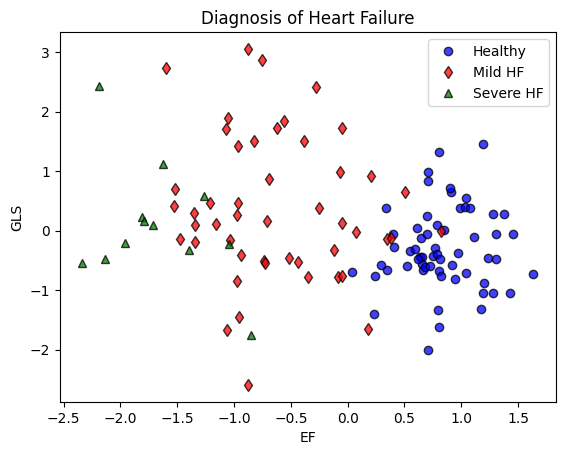

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

# read fine into a dataframe object
df = pd.read_csv('data/heart_failure_data_complete.csv')
# convert dataframe to numpy array
data = df.to_numpy()
# Create feature matrix with EF and GLS
X = data[:,[1,2]]
X = StandardScaler().fit_transform(X)
# Create label vector 
y = data[:,0]
# print properties
print('Feature matrix X dimensions: ', X.shape)
print('Target vector y dimensions: ', y.shape)
print('Labels: ', np.unique(y))

def PlotData(X,y):
    # plot class 0
    plt.plot(X[y==0,0],X[y==0,1],'bo',alpha=0.75,markeredgecolor='k',label = 'Healthy')
    # plot class 1
    plt.plot(X[y==1,0],X[y==1,1],'rd',alpha=0.75,markeredgecolor='k',label = 'Mild HF')
    # plot class 2
    plt.plot(X[y==2,0],X[y==2,1],'g^',alpha=0.75,markeredgecolor='k',label = 'Severe HF')
    
    # annotate the plot
    plt.title('Diagnosis of Heart Failure')
    plt.xlabel('EF')
    plt.ylabel('GLS')
    plt.legend()

# call the function to plot the dataset
PlotData(X,y)

### Functions
The cell bellow contains some of the functions that we have created in the previous notebook and which can be reused for multilabel classification. These functions are
* `PlotClassification`
* `PlotProbabilities`
* `Accuracy_CV`

Run the cell.

In [2]:
def PlotClassification(model,X,y):

    # Create an 1D array of samples for each feature
    x1 = np.linspace(-2.5, 2, 1000) 
    x2 = np.linspace(-3, 3.5, 1000).T # note the transpose
    # Creates 2D arrays that hold the coordinates in 2D feature space
    x1, x2 = np.meshgrid(x1, x2) 
    # Flatten x1 and x2 to 1D vector and concatenate into a feature matrix
    Feature_space = np.c_[x1.ravel(), x2.ravel()] 

    # Predict labels for the whole feature space    
    y_pred = model.predict(Feature_space)
    # Resahpe to 2D
    y_pred = y_pred.reshape(x1.shape)
    # Plot using contourf
    plt.contourf(x1, x2, y_pred, cmap = 'summer')
    
    # Plot data
    PlotData(X,y)

def PlotProbabilities(model,X,y,label=1):

    # Create an 1D array of samples for each feature
    x1 = np.linspace(-2.5, 2, 1000) 
    x2 = np.linspace(-3, 3.5, 1000).T # note the transpose
    # Creates 2D arrays that hold the coordinates in 2D feature space
    x1, x2 = np.meshgrid(x1, x2) 
    # Flatten x1 and x2 to 1D vector and concatenate into a feature matrix
    Feature_space = np.c_[x1.ravel(), x2.ravel()] 

    # Predict labels for the whole feature space    
    proba = model.predict_proba(Feature_space)
    # Select the class
    p = proba[:,label]
    # Resahpe to 2D
    p = p.reshape(x1.shape)
    # Plot using contourf
    plt.contourf(x1, x2, p, cmap = 'summer')
    
    # Plot data
    PlotData(X,y)
    
def Accuracy_CV(model,X,y):
    scores = cross_val_score(model,X,y)
    print('Accuracy CV: ',round(scores.mean(),2))

### Fit and plot the model
We will first fit the logistic regression model to the data. Run the cell bellow.

In [3]:
# create model
model = LogisticRegression()

# Fit the model
model.fit(X,y)

LogisticRegression()

**Activity 1:** Plot the classification labels using `PlotClassification`

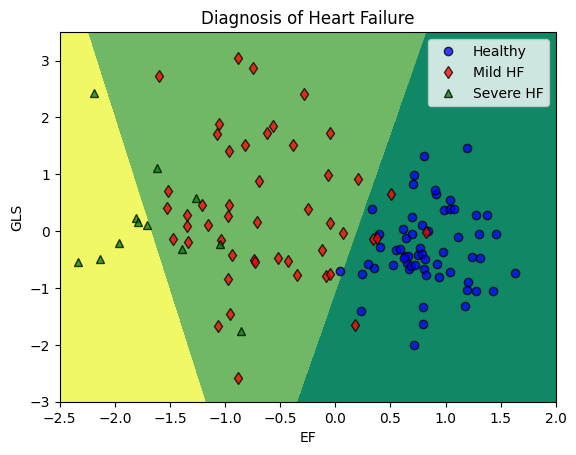

In [4]:
PlotClassification(model,X,y)

**Activity 2:** Plot probabilities for all three classes in the same figure

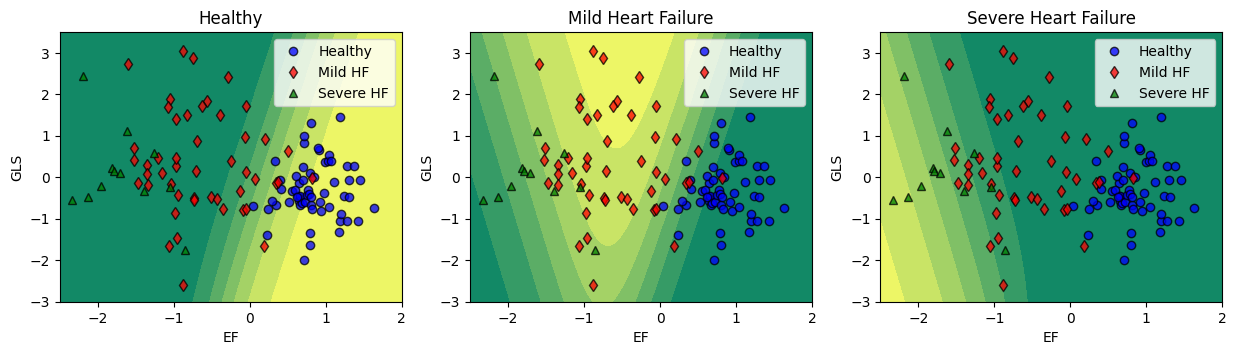

In [5]:
plt.figure(figsize=(15,3.5))
classes = ['Healthy','Mild Heart Failure', 'Severe Heart Failure']
for i in range(3):
    plt.subplot(1,3,i+1)
    PlotProbabilities(model,X,y,label=i)
    plt.title(classes[i])

### Accuracy
**Activity 3:** Evaluate cross-validated accuracy of the model using `Accuracy_CV`. Is the performance good? To see whether accuracy is reliable measure of performance, calculate the number of samples in each class. Is the dataset balanced?

**Answer:** Accuracy 0.89 is quite high, however the dataset is not balanced. We therefore need to further analyse the performance of the model.

In [6]:
# Evaluate accuracy
Accuracy_CV(model,X,y)

# check for class imbalance
print('Number of samples of class 0: ', y[y==0].shape[0])
print('Number of samples of class 1: ', y[y==1].shape[0])
print('Number of samples of class 2: ', y[y==2].shape[0])

Accuracy CV:  0.89
Number of samples of class 0:  60
Number of samples of class 1:  48
Number of samples of class 2:  12


### Recall

The function `Recall_CV` calculates different type of recalls that help us analyse the performance of the multilabel classifier. These can be set by parameter `average`:

* `average=None` will return recall for each class. We can find out how well the classifier indentifies each class.
* `average=macro` will return recall average over the classes. This measure is sensitive to the performance of individual classes irrespective of their sizes.
* `average=micro` will return recall averaged over the samples, e.g. the recall is calculated globally by counting the total true positives, false negatives and false positives. This measure is not very sensitive to the classes of small sizes.

**Activity 4**: Calculate different types of recalls by calling the function `Recall_CV`. What can you tell about the performance of the classifier for different classes? How do the different average recalls compare to the accuracy score?

**Answer:** Recall is very low for class 2. This is better reflected in average recall over all classes `macro`, which dropped to 0.79 as a result. Setting `micro` returns result similar to accuracy 0.89. The class imballance therefore affected the accuracy measure, that did not properly reflect the poor performance of the classifier to detect patients with severe heart failure.

In [7]:
def Recall_CV(model,X,y):
    # predict labels using cross-validation
    y_pred = cross_val_predict(model,X,y)
    
    # calculate recalls for all classes
    recalls = recall_score(y,y_pred,average=None)
    print('Recalls for all classes: ', np.around(recalls,2))
    
    # calculate recall averaged over classes
    mean_recall_macro = recall_score(y,y_pred,average='macro')
    print('Average Recall macro: ', np.around(mean_recall_macro,2))
    
    # calculate recall averaged over samples
    mean_recall_micro = recall_score(y,y_pred,average='micro')
    print('Average Recall micro: ', np.around(mean_recall_micro,2))

# Calculate recalls
Recall_CV(model,X,y)

Recalls for all classes:  [0.98 0.88 0.5 ]
Average Recall macro:  0.79
Average Recall micro:  0.89


### Confusion matrix
The code bellow calculate and plots the confusion matrix. Run the code.

<Axes: >

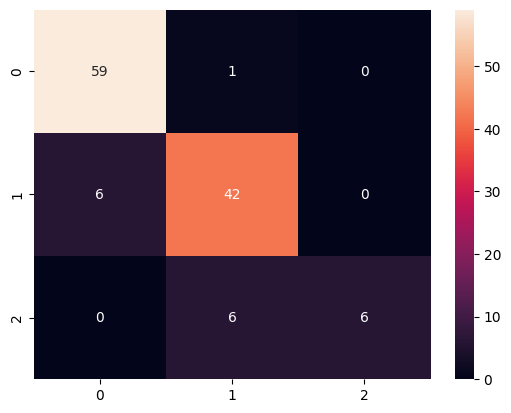

In [8]:
# predict labels using cross-validation
y_pred = cross_val_predict(model, X, y, cv=5)

# calculate confusion matrix
cm = confusion_matrix(y, y_pred);
sns.heatmap(cm, annot=True)

**Activity 5:** Set the diagonal to zero and describe the main sources of misclassification.

**Answer:** The main sources of misclassification are
* Mild heart failure diagnosed as healthy
* Severe heart failure diagnosed as mild

<Axes: >

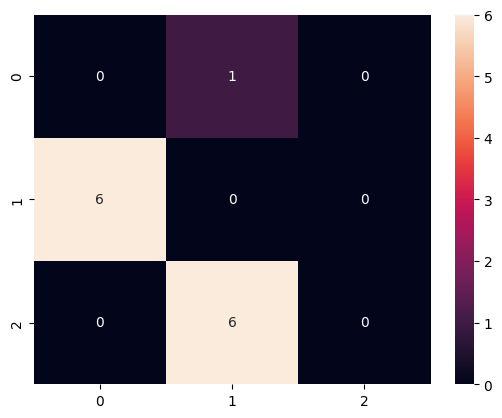

In [9]:
# set diagonal to zero
np.fill_diagonal(cm, 0)

sns.heatmap(cm, annot=True)

## Exercise 3: Balanced multi-label classification (optional)

One way to deal with class imbalance is to increase the weight of the samples of smaller classes in the classification loss. For `LogisticRegression` this can be done by setting `class_weight='balanced'`, which will weight the sample inversly to the class size, this giving equal importance to each class irrespective of its size. 

In this exercise you will fit the logistic regression with class weighting and analyse the performance of the balanced model.

### Task 1: Fit and plot the balanced model

Fit the logistic regression with `class_weight='balanced'` and plot the classification boundaries/labels.

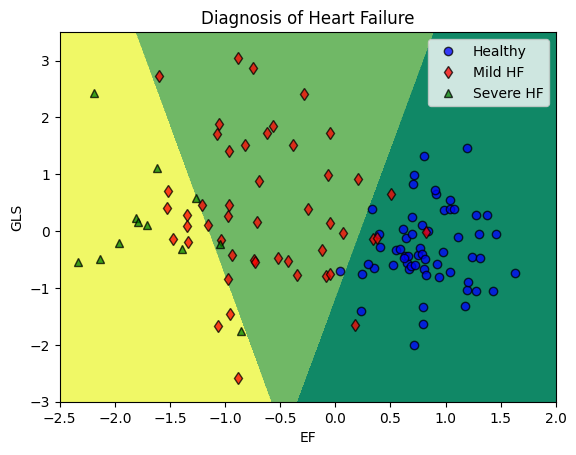

In [10]:
# create the balanced logistic regression model
model2 = LogisticRegression(class_weight='balanced')

# fit the model
model2.fit(X,y)

# plot classification
PlotClassification(model2,X,y)

### Task 2: Accuracy
Calculate the cross-validated accuracy of the balanced model. Was it affected by the change in weighting of the samples?

**Answer:** Yes, the accuracy dropped from 0.89 to 0.83.

In [11]:
# Calculate CV accuracy
Accuracy_CV(model2,X,y)

Accuracy CV:  0.83


### Task 3: Recall

Calculate different types of cross-validated recalls. What has change in the performance of the classifier compared to the unballanced version?

**Answer:** There is now higher performance for the smallest class - Severe HF, which improved from 0.5 to 0.83. Hovewer this is at the expense of the mild HF which decreased from 0.88 to 0.65. Average recall over all classes increased from 0.79 to 0.82.

In [12]:
Recall_CV(model2,X,y)

Recalls for all classes:  [0.98 0.65 0.83]
Average Recall macro:  0.82
Average Recall micro:  0.83


### Task 4: Confusion matrix
Calculate and plot the confusion matrix to identify main types of misclassifications.

<Axes: >

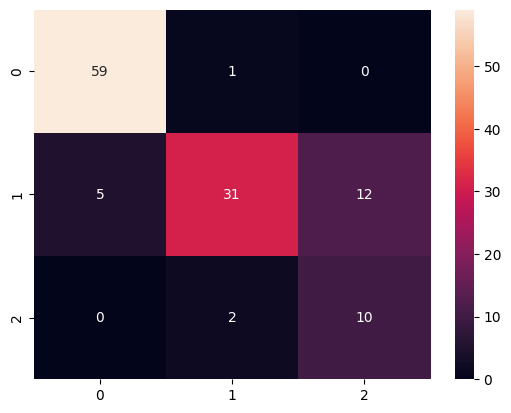

In [13]:
# predict labels using cross-validation
y_pred = cross_val_predict(model2, X, y, cv=5)

# calculate confusion matrix
cm = confusion_matrix(y, y_pred);
sns.heatmap(cm, annot=True)

<Axes: >

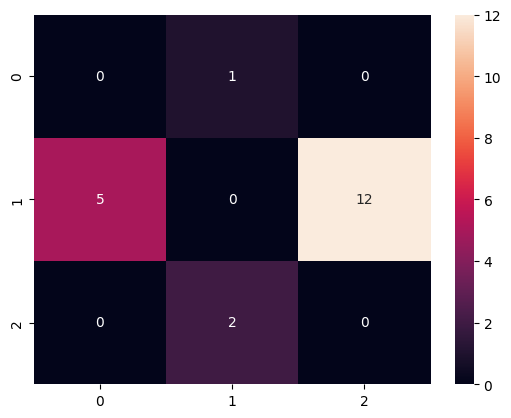

In [14]:
# set diagonal to zero
np.fill_diagonal(cm, 0)
sns.heatmap(cm, annot=True)

**Answer:** The main types of misclassifications are:
* Mild HF classified as Severe HF (12 samples)
* Mild HF classified as Healthy (5 samples)